# Synthetic CDS Data Generation

**Outputs:**
- Time series of 5Y CDS spreads (monthly)
- CDS curve snapshot (term structure)

**Time series model:** Log-OU
```
d(log S) = κ(log θ - log S)dt + σ√dt dW
```

**Curve model:** Exponential saturation
```
spread(T) = spread_5Y × (1 - e^(-kT)) / (1 - e^(-5k))
```

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append('..')

In [19]:
import importlib
import data.generator
importlib.reload(data.generator)
from data.generator import CDSDataGenerator, EntityConfig, Regime

---
## 1. Configuration

In [20]:
# Output paths
OUTPUT_TIME_SERIES = "synthetic_cds_5y_monthly.csv"
OUTPUT_CURVE = "synthetic_cds_curve.csv"
SEED = 42

### 1.1 Reference Entities

In [21]:
entities = [
    EntityConfig(
        name="Alpha Bank Corp",
        ticker="ALPHA",
        sector="financials",
        base_spread_5y=75,
        volatility_pct=0.35,
        mean_reversion_speed=1.0
    ),
    EntityConfig(
        name="Beta Energy Inc",
        ticker="BETA",
        sector="energy",
        base_spread_5y=55,
        volatility_pct=0.40,
        mean_reversion_speed=0.8
    ),
    EntityConfig(
        name="Gamma Tech Ltd",
        ticker="GAMMA",
        sector="tech",
        base_spread_5y=45,
        volatility_pct=0.30,
        mean_reversion_speed=1.2
    ),
    EntityConfig(
        name="Delta Industrial Co",
        ticker="DELTA",
        sector="industrials",
        base_spread_5y=100,
        volatility_pct=0.45,
        mean_reversion_speed=0.7
    ),
    EntityConfig(
        name="Epsilon Telecom",
        ticker="EPSILON",
        sector="telecoms",
        base_spread_5y=65,
        volatility_pct=0.25,
        mean_reversion_speed=1.0
    ),
]

pd.DataFrame([{
    "Ticker": e.ticker,
    "Sector": e.sector,
    "Base 5Y (bps)": e.base_spread_5y,
    "Vol": f"{e.volatility_pct:.0%}",
    "κ": e.mean_reversion_speed
} for e in entities])

,Ticker,Sector,Base 5Y (bps),Vol,κ
0,ALPHA,financials,75,35%,1.0
1,BETA,energy,55,40%,0.8
2,GAMMA,tech,45,30%,1.2
3,DELTA,industrials,100,45%,0.7
4,EPSILON,telecoms,65,25%,1.0


### 1.2 Correlation Matrix

In [22]:
correlation_matrix = np.array([
    [1.00, 0.35, 0.40, 0.45, 0.50],
    [0.35, 1.00, 0.25, 0.55, 0.30],
    [0.40, 0.25, 1.00, 0.35, 0.45],
    [0.45, 0.55, 0.35, 1.00, 0.40],
    [0.50, 0.30, 0.45, 0.40, 1.00],
])

tickers = [e.ticker for e in entities]
pd.DataFrame(correlation_matrix, index=tickers, columns=tickers)

,ALPHA,BETA,GAMMA,DELTA,EPSILON
ALPHA,1.00,0.35,0.40,0.45,0.50
BETA,0.35,1.00,0.25,0.55,0.30
GAMMA,0.40,0.25,1.00,0.35,0.45
DELTA,0.45,0.55,0.35,1.00,0.40
EPSILON,0.50,0.30,0.45,0.40,1.00


### 1.3 Regimes

In [23]:
regimes = [
    Regime("pre_covid", "2016-01", "2020-02", 1.0, 0.0, 1.0),
    Regime("covid_stress", "2020-03", "2020-06", 2.5, 0.8, 1.5),
    Regime("covid_recovery", "2020-07", "2021-06", 1.5, 0.3, 1.2),
    Regime("post_covid", "2021-07", "2023-02", 1.0, 0.0, 1.0),
    Regime("banking_stress", "2023-03", "2023-06", 1.8, 0.4, 1.3),
    Regime("final", "2023-07", "2025-12", 1.0, 0.0, 1.0),
]

pd.DataFrame([{
    "Regime": r.name, "Period": f"{r.start} → {r.end}",
    "Vol×": r.vol_multiplier, "Spread+": f"{r.spread_shift_pct:.0%}"
} for r in regimes])

,Regime,Period,Vol×,Spread+
0,pre_covid,2016-01 → 2020-02,1.0,0%
1,covid_stress,2020-03 → 2020-06,2.5,80%
2,covid_recovery,2020-07 → 2021-06,1.5,30%
3,post_covid,2021-07 → 2023-02,1.0,0%
4,banking_stress,2023-03 → 2023-06,1.8,40%
5,final,2023-07 → 2025-12,1.0,0%


### 1.4 Curve Parameters

**Exponential saturation:** `spread(T) = spread_5Y × (1 - e^(-kT)) / (1 - e^(-5k))`

| k | 1Y % of 5Y | 5Y/1Y |
|---|------------|-------|
| 0.30 | 33% | 3.0x |
| 0.50 | 43% | 2.3x |
| 0.70 | 51% | 2.0x |

In [24]:
CURVE_AS_OF_DATE = "2025-12-31"
TENORS = [1, 2, 3, 4, 5]
RECOVERY_RATE = 0.40

# Curve steepness: k = BASE_K + SPREAD_SENSITIVITY × spread_5y
# Lower k = steeper curve (low spread names)
# Higher k = flatter curve (high spread names)
BASE_K = 0.30
SPREAD_SENSITIVITY = 0.002  # each 100bps adds 0.2 to k

---
## 2. Generate Data

In [25]:
gen = CDSDataGenerator(seed=SEED)
gen.set_entities(entities)
gen.set_correlation_matrix(correlation_matrix)
gen.set_regimes(regimes)

ts_df = gen.generate_time_series(start="2016-01-31", end="2025-12-31", freq="M")
print(f"Time series: {len(ts_df)} rows, {ts_df['date'].min().date()} to {ts_df['date'].max().date()}")

curve_df = gen.generate_curve_snapshot(
    as_of=CURVE_AS_OF_DATE,
    tenors=TENORS,
    recovery_rate=RECOVERY_RATE,
    base_k=BASE_K,
    spread_sensitivity=SPREAD_SENSITIVITY
)
print(f"Curve: {len(curve_df)} rows")

Time series: 600 rows, 2016-01-31 to 2025-12-31
Curve: 25 rows


d:\cqf-cds-pricing\data\..\data\generator.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start=start, end=end, freq=freq)


---
## 3. Validation

### 3.1 Time Series

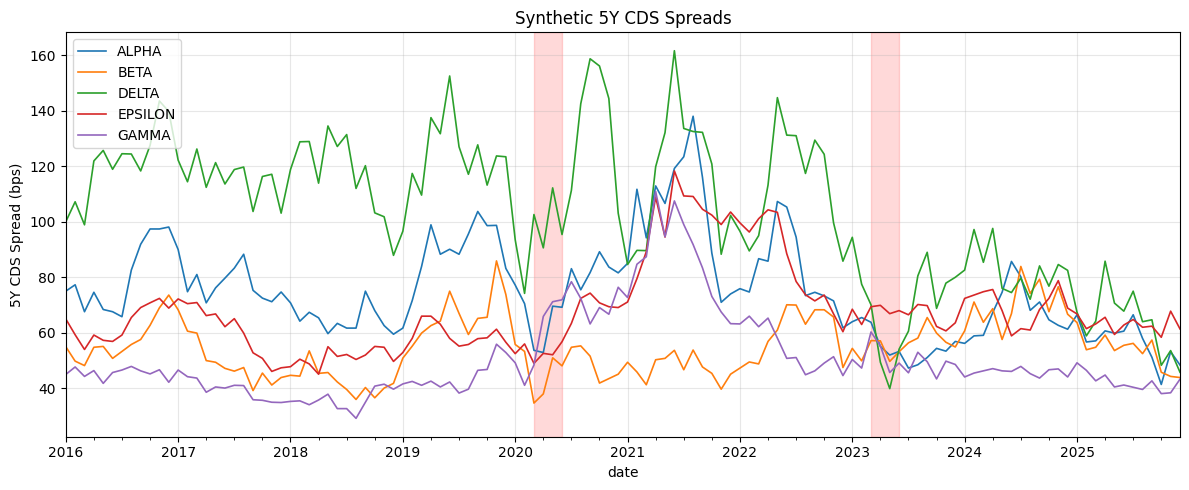

In [26]:
ts_wide = ts_df.pivot(index="date", columns="ticker", values="cds_5y_spread_bps")

fig, ax = plt.subplots(figsize=(12, 5))
ts_wide.plot(ax=ax, linewidth=1.2)
for start, end in [("2020-03-01", "2020-06-30"), ("2023-03-01", "2023-06-30")]:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.15, color="red")
ax.set_ylabel("5Y CDS Spread (bps)")
ax.set_title("Synthetic 5Y CDS Spreads")
ax.legend(loc="upper left")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
ts_wide.describe().round(1)

ticker,ALPHA,BETA,DELTA,EPSILON,GAMMA
count,120.0,120.0,120.0,120.0,120.0
mean,75.1,54.9,103.8,67.9,50.9
std,17.8,10.6,26.8,15.7,15.8
min,41.4,34.7,39.9,45.1,29.2
25%,61.8,47.1,84.5,58.0,41.2
50%,72.0,54.2,105.4,65.3,46.3
75%,85.2,61.4,124.3,71.7,52.9
max,138.0,85.9,161.6,118.3,110.9


### 3.2 Correlation

In [28]:
gen.get_correlation_comparison()

,pair,target,realised,diff
0,ALPHA-BETA,0.35,0.409296,0.059296
1,ALPHA-GAMMA,0.40,0.340229,-0.059771
2,ALPHA-DELTA,0.45,0.368285,-0.081715
3,ALPHA-EPSILON,0.50,0.355101,-0.144899
4,BETA-GAMMA,0.25,0.275383,0.025383
5,BETA-DELTA,0.55,0.466719,-0.083281
6,BETA-EPSILON,0.30,0.353181,0.053181
7,GAMMA-DELTA,0.35,0.266907,-0.083093
8,GAMMA-EPSILON,0.45,0.511096,0.061096
9,DELTA-EPSILON,0.40,0.426064,0.026064


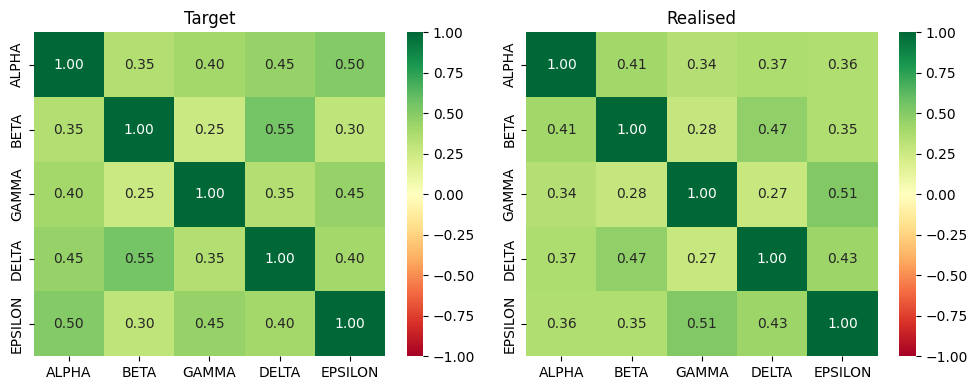

In [29]:
realised_corr = gen.get_realised_correlation()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="RdYlGn", center=0,
            xticklabels=tickers, yticklabels=tickers, vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title("Target")
sns.heatmap(realised_corr, annot=True, fmt=".2f", cmap="RdYlGn", center=0,
            xticklabels=tickers, yticklabels=tickers, vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title("Realised")
plt.tight_layout()
plt.show()

### 3.3 CDS Curves

In [30]:
# Show k values and resulting ratios
curve_summary = curve_df[curve_df["tenor_years"] == 5][["ticker", "cds_5y_spread_bps", "curve_k"]].copy()
curve_1y = curve_df[curve_df["tenor_years"] == 1][["ticker", "cds_spread_bps"]].rename(columns={"cds_spread_bps": "cds_1y"})
curve_summary = curve_summary.merge(curve_1y, on="ticker")
curve_summary["5Y/1Y ratio"] = (curve_summary["cds_5y_spread_bps"] / curve_summary["cds_1y"]).round(2)
curve_summary

,ticker,cds_5y_spread_bps,curve_k,cds_1y,5Y/1Y ratio
0,ALPHA,48.4,0.397,18.4,2.63
1,BETA,43.9,0.388,16.5,2.66
2,GAMMA,43.3,0.387,16.2,2.67
3,DELTA,45.8,0.392,17.3,2.65
4,EPSILON,61.4,0.423,24.1,2.55


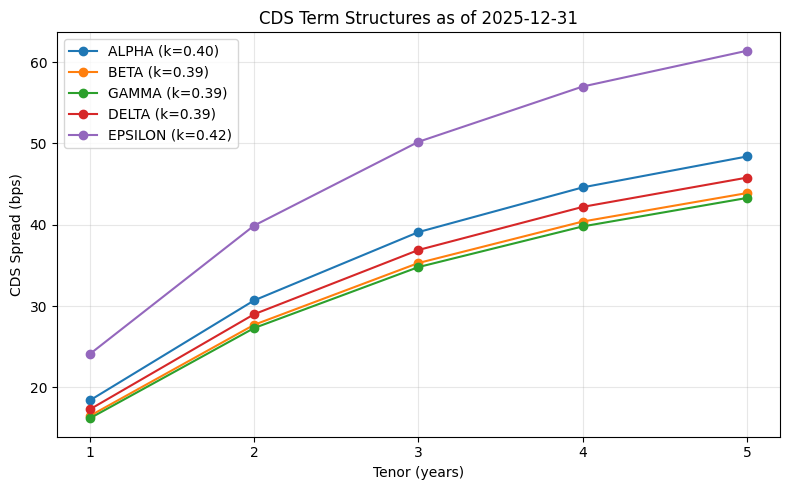

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
for ticker in tickers:
    ec = curve_df[curve_df["ticker"] == ticker]
    k = ec["curve_k"].iloc[0]
    ax.plot(ec["tenor_years"], ec["cds_spread_bps"], marker="o", label=f"{ticker} (k={k:.2f})")

ax.set_xlabel("Tenor (years)")
ax.set_ylabel("CDS Spread (bps)")
ax.set_title(f"CDS Term Structures as of {CURVE_AS_OF_DATE}")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(TENORS)
plt.tight_layout()
plt.show()

In [32]:
# Show decreasing deltas between tenors
curve_pivot = curve_df.pivot(index="tenor_years", columns="ticker", values="cds_spread_bps")
deltas = curve_pivot.diff().iloc[1:]
print("Spread deltas between tenors (should decrease):")
deltas.round(1)

Spread deltas between tenors (should decrease):


ticker,ALPHA,BETA,DELTA,EPSILON,GAMMA
tenor_years,,,,,
2,12.3,11.2,11.7,15.8,11.1
3,8.4,7.6,7.9,10.3,7.5
4,5.5,5.1,5.3,6.8,5.0
5,3.8,3.5,3.6,4.4,3.5


---
## 4. Save

In [33]:
gen.save_time_series(OUTPUT_TIME_SERIES)
gen.save_curve(curve_df, OUTPUT_CURVE)
print(f"✓ Saved: {OUTPUT_TIME_SERIES}")
print(f"✓ Saved: {OUTPUT_CURVE}")

✓ Saved: synthetic_cds_5y_monthly.csv
✓ Saved: synthetic_cds_curve.csv


---
## 5. Summary

In [34]:
print(f"Seed: {SEED}")
print(f"\nCurve: base_k={BASE_K}, spread_sensitivity={SPREAD_SENSITIVITY}")
print(f"Recovery rate: {RECOVERY_RATE}")

Seed: 42

Curve: base_k=0.3, spread_sensitivity=0.002
Recovery rate: 0.4
